# Causal Inference Crash Course: Income and Employment Outcomes

## Abstract
This notebook employs formal causal inference techniques to address two distinct inquiries utilizing distinct datasets and causal structures. In the initial instance, I investigate the causal relationship between holding a graduate degree and higher income, employing the UCI Adult Census dataset. While graduate degree holders generally earn more on average, this association is confounded by factors such as age, occupation, and hours worked. To mitigate these confounders, I employ propensity score matching via the DoWhy library to estimate the causal effect. In the second instance, I utilize the LaLonde dataset from the National Supported Work Demonstration to estimate the causal effect of a job training program on earnings. Given that treatment was randomly assigned in this study, it serves as a validation of the causal methods adjustment’s minimal impact when confounding is already absent. Concurrently, these examples elucidate the circumstances in which causal reasoning is paramount and when it merely corroborates the effects of randomization. For machine learning practitioners, comprehending causal structure is of utmost importance. Models trained without accounting for confounders can inadvertently learn spurious relationships that fail under intervention. Readers will acquire the skills to construct causal graphs, apply propensity score methods, conduct refutation tests, and critically assess causal assumptions.

## Correlation vs Causation
In predictive machine learning, we predict income based on known factors. Causal inference asks if a specific action (e.g., earning a graduate degree) causes a change in income. Judea Pearl distinguishes between seeing and doing. Observing that graduate degree holders earn more doesn’t mean the degree caused the higher income. People who pursue graduate degrees are often older, work more hours, and are already in higher-paying careers. These pre-existing factors, not just the degree, may explain the income gap. Ignoring these factors confuses correlation with causation.

## Key Causal Concepts
Confounders are variables that influence both the treatment and the outcome. In our income analysis, age is a confounder. Older individuals are more likely to have completed a graduate degree and earn over 50K due to career progression. If we don’t adjust for age, we’ll attribute income differences to education that are actually driven by age.

Directed Acyclic Graphs (DAGs) are visual tools for encoding causal assumptions. Each node represents a variable, and each arrow represents a direct causal relationship. DAGs help us identify which variables to control for and which to leave alone. The backdoor criterion determines the minimum set of variables needed to block all non-causal paths between treatment and outcome.

Colliders are variables caused by two or more other variables. Conditioning on a collider opens a spurious association between its causes. For example, being in a prestigious occupation might be caused by both education and natural ability. Controlling for occupation could introduce bias by creating a false association between education and ability, distorting our estimate of education’s effect on income.

Mediators are variables that lie on the causal pathway between treatment and outcome. Occupation is a potential mediator between education and income. Education causes certain job placements, which in turn cause higher pay. To estimate the total causal effect of education on income, we shouldn’t condition on mediators, as doing so would block part of the effect we’re trying to measure.

## Identification Strategies
Propensity Score Matching: When conducting randomized experiments is not feasible, propensity score matching provides a method to approximate one from observational data. The propensity score represents the probability of receiving treatment based on a set of observed covariates. In our income analysis, it is the probability that an individual holds a graduate degree given their age, sex, race, hours worked, and other characteristics. By matching individuals with similar propensity scores but differing in their treatment status, we establish a comparison that closely resembles random assignment. The fundamental assumption is unconfoundedness, which implies that after conditioning on observed covariates, treatment assignment is as random as possible. However, if there are significant unmeasured confounders, this assumption is violated, leading to biased estimates.

Inverse Propensity Weighting (IPW): An alternative to matching, IPW reweights each observation by the inverse of its probability of receiving the treatment it actually received. Individuals who were unlikely to be treated receive higher weights, while those who were likely to be treated receive higher weights as well. This reweighting creates a pseudo-population where treatment is independent of confounders. IPW and matching rely on the same unconfoundedness assumption but employ distinct mechanisms, enabling a comparison of their estimates to assess robustness.

Applying the Same Method Across Different Settings: In this notebook, I apply propensity score methods to two distinct settings: one observational (UCI Adult Census) and one experimental (LaLonde job training). In the observational setting, confounders are present, and causal adjustment significantly alters the estimate. In the experimental setting, randomization has already balanced confounders, suggesting minimal impact from adjustment. This contrast highlights both the necessity of causal methods and the validation that these methods do not distort results when confounding is absent.



## Data Preparation for Causal Analysis
Data preparation for causal inference fundamentally differs from preparation for predictive modeling. In prediction, feature selection is based on their predictive power, while in causal inference, the Directed Acyclic Graph (DAG) determines variable inclusion regardless of predictive strength.
Confounders must be included even if they are weak predictors. For instance, race may have modest predictive power for income, but if it influences both the likelihood of obtaining a graduate degree and income outcomes, omitting it would bias the causal estimate. Conversely, mediators and colliders must be excluded from conditioning even if they are strong predictors.
Missing data necessitates careful treatment in causal analysis. If the probability of a value being missing is related to both the treatment and outcome, the missingness itself introduces confounding. Before selecting an imputation strategy, it is crucial to assess whether data is missing completely at random (MCAR), missing at random (MAR), or missing not at random (MNAR).
Temporal ordering is paramount. Variables used as confounders must be measured before treatment assignment. Conditioning on a variable measured after treatment risks adjusting for a consequence of treatment rather than a cause.
When encoding categorical variables such as education level or occupation for use in propensity score models, one-hot encoding is preferred over ordinal encoding because it does not impose an arbitrary ordering on categories that may not have a natural hierarchy.


## Example 1 Causal Effect of Graduate Education on Income (Observational Study – UCI Adult Dataset)

## Dataset Description
For this example, I use the UCI Adult Census dataset (1994) obtained from the UCI Machine Learning Repository. The dataset contains 32,561 observations and 15 variables describing demographic characteristics, education levels, employment information, and income categories for individuals in the United States.
Key variables include:

education (categorical education level)

age

sex

race

marital_status

workclass

hours_per_week

income (binary outcome: >50K or ≤50K)

This dataset is commonly used for predictive modeling tasks. However, in this assignment, I approach it from a causal inference perspective rather than a predictive one.

# Causal Question and Problem Setup

The primary causal question is:
Does holding a graduate degree cause an individual to earn more than $50,000 per year?

Treatment (T)
Graduate degree status:

1 = Masters, Doctorate, or Professional School
0 = No graduate degree

Outcome (Y)
High income status:

1 = Income greater than $50000
0 = Income less than or equal to  $50000

Potential Confounders (W)
The relationship between education and income is not randomized. Individuals who obtain graduate degrees may differ systematically from those who do not. I control for the following potential confounders:

Age (career progression)

Sex

Race

Marital status

Hours worked per week

Workclass (employment type)

These variables may influence both the likelihood of obtaining a graduate degree and the probability of earning a high income.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 
           'marital_status', 'occupation', 'relationship', 'race', 'sex',
           'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income']

df = pd.read_csv(url, header=None, names=columns, skipinitialspace=True)
print(df.shape)
df.head()

(32561, 15)


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# Data Preparation and Naive Comparison
Before applying any causal methods, I first construct the treatment and outcome variables from the raw data. I then compute a naive comparison of income rates between graduate degree holders and non-holders. This unadjusted estimate serves as a baseline that does not account for confounding. We expect this number to overstate the true causal effect of a graduate degree because it captures both the effect of education and the influence of confounders like age and hours worked.

In [10]:
# Creating binary treatment variable: 1 = graduate degree, 0 = no graduate degree
df['grad_degree'] = df['education'].isin(['Masters', 'Doctorate', 'Prof-school']).astype(int)

In [11]:
# Creating binary outcome variable: 1 = income >50K, 0 = income <=50K
df['high_income'] = (df['income'].str.strip() == '>50K').astype(int)

# Checking the counts
print("Treatment distribution:")
print(df['grad_degree'].value_counts())
print("\nOutcome distribution:")
print(df['high_income'].value_counts())



Treatment distribution:
grad_degree
0    29849
1     2712
Name: count, dtype: int64

Outcome distribution:
high_income
0    24720
1     7841
Name: count, dtype: int64


In [12]:
# Naive comparison — no causal adjustment
naive_rates = df.groupby('grad_degree')['high_income'].mean()
naive_ate = naive_rates[1] - naive_rates[0]

print(f"\nIncome >50K rate for non-grad degree holders: {naive_rates[0]:.1%}")
print(f"Income >50K rate for grad degree holders: {naive_rates[1]:.1%}")
print(f"\nNaive ATE (unadjusted): {naive_ate:.4f} ({naive_ate:.1%})")
print("\nThis estimate is BIASED — grad degree holders differ systematically from non-holders.")


Income >50K rate for non-grad degree holders: 20.6%
Income >50K rate for grad degree holders: 62.2%

Naive ATE (unadjusted): 0.4163 (41.6%)

This estimate is BIASED — grad degree holders differ systematically from non-holders.


# Exploratory Causal Analysis: Visualizing Confounding
To understand why the naive estimate is biased, I examine how graduate degree holders differ from non-holders across key confounders. If these groups look different on variables that also affect income, then the naive comparison conflates the effect of education with the effect of those other variables.

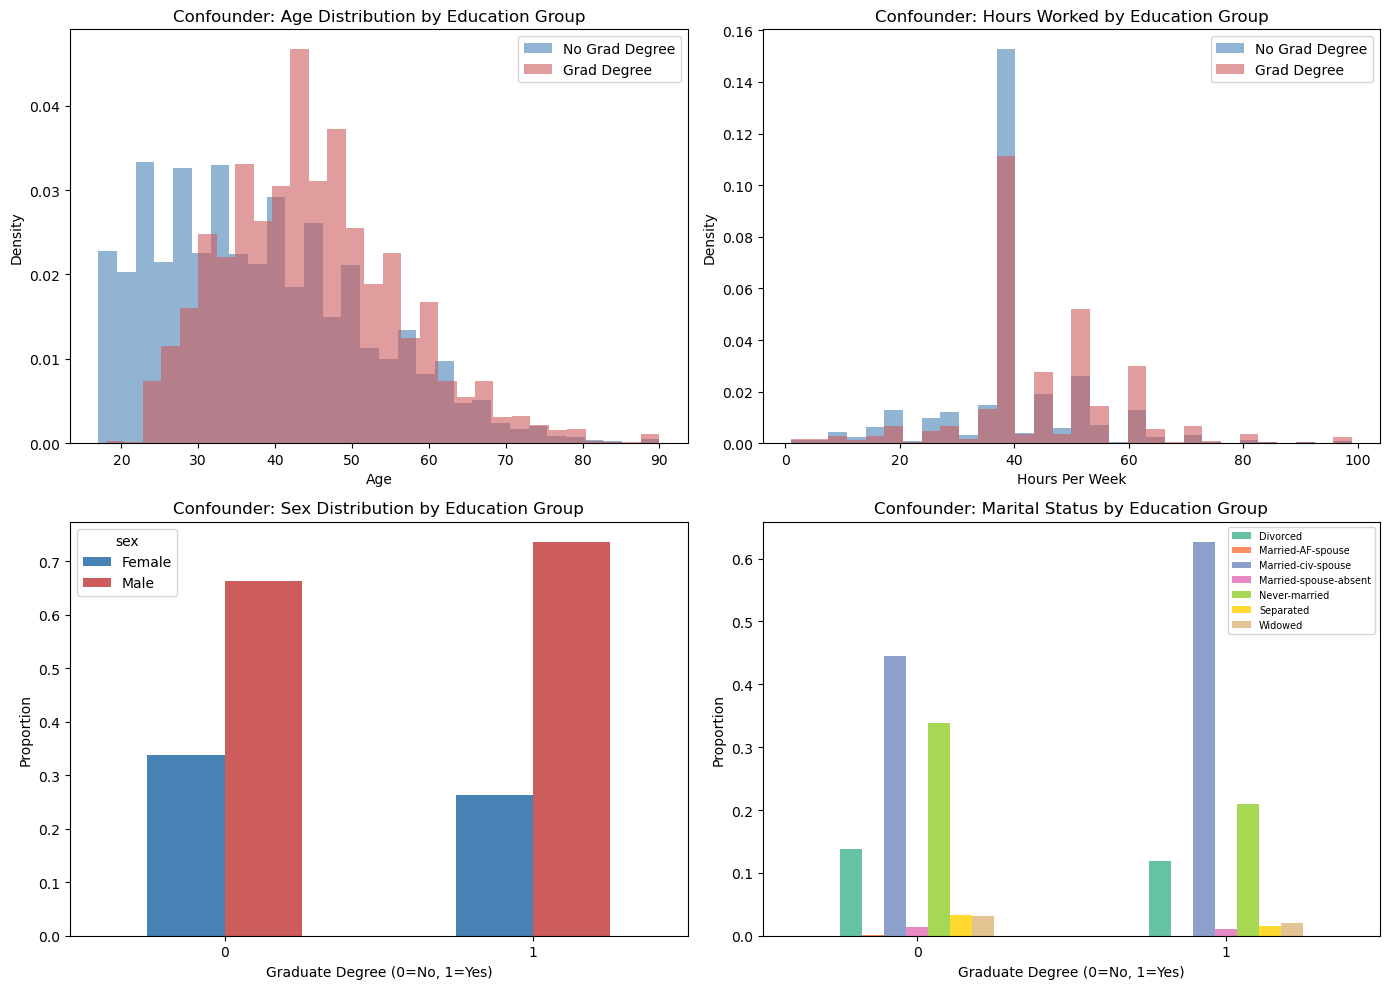


Mean age - No grad degree: 38.0
Mean age - Grad degree: 44.8

Mean hours/week - No grad degree: 40.0
Mean hours/week - Grad degree: 45.1


In [14]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Age distribution by treatment group
axes[0, 0].hist(df[df['grad_degree']==0]['age'], bins=30, alpha=0.6, 
                label='No Grad Degree', color='steelblue', density=True)
axes[0, 0].hist(df[df['grad_degree']==1]['age'], bins=30, alpha=0.6, 
                label='Grad Degree', color='indianred', density=True)
axes[0, 0].set_xlabel('Age')
axes[0, 0].set_ylabel('Density')
axes[0, 0].set_title('Confounder: Age Distribution by Education Group')
axes[0, 0].legend()

# 2. Hours per week distribution
axes[0, 1].hist(df[df['grad_degree']==0]['hours_per_week'], bins=30, alpha=0.6, 
                label='No Grad Degree', color='steelblue', density=True)
axes[0, 1].hist(df[df['grad_degree']==1]['hours_per_week'], bins=30, alpha=0.6, 
                label='Grad Degree', color='indianred', density=True)
axes[0, 1].set_xlabel('Hours Per Week')
axes[0, 1].set_ylabel('Density')
axes[0, 1].set_title('Confounder: Hours Worked by Education Group')
axes[0, 1].legend()

# 3. Sex distribution
sex_data = df.groupby(['grad_degree', 'sex']).size().unstack(fill_value=0)
sex_data_pct = sex_data.div(sex_data.sum(axis=1), axis=0)
sex_data_pct.plot(kind='bar', ax=axes[1, 0], color=['steelblue', 'indianred'])
axes[1, 0].set_xlabel('Graduate Degree (0=No, 1=Yes)')
axes[1, 0].set_ylabel('Proportion')
axes[1, 0].set_title('Confounder: Sex Distribution by Education Group')
axes[1, 0].tick_params(axis='x', rotation=0)

# 4. Marital status distribution
marital_data = df.groupby(['grad_degree', 'marital_status']).size().unstack(fill_value=0)
marital_data_pct = marital_data.div(marital_data.sum(axis=1), axis=0)
marital_data_pct.plot(kind='bar', ax=axes[1, 1], color=plt.cm.Set2.colors)
axes[1, 1].set_xlabel('Graduate Degree (0=No, 1=Yes)')
axes[1, 1].set_ylabel('Proportion')
axes[1, 1].set_title('Confounder: Marital Status by Education Group')
axes[1, 1].tick_params(axis='x', rotation=0)
axes[1, 1].legend(fontsize=7)

plt.tight_layout()
plt.show()

print("\nMean age - No grad degree:", df[df['grad_degree']==0]['age'].mean().round(1))
print("Mean age - Grad degree:", df[df['grad_degree']==1]['age'].mean().round(1))
print("\nMean hours/week - No grad degree:", df[df['grad_degree']==0]['hours_per_week'].mean().round(1))
print("Mean hours/week - Grad degree:", df[df['grad_degree']==1]['hours_per_week'].mean().round(1))


# Interpretation of Confounding
The plots confirm that graduate degree holders differ systematically from non-holders across multiple dimensions. They are older on average (44 vs 38), work more hours per week, are more likely to be male, and are more likely to be married. Each of these variables independently affects income. This means the naive 41.6 percentage point difference between the two groups conflates the effect of education with the effects of age, sex, hours worked, and marital status. To isolate the causal effect of holding a graduate degree, we must adjust for these confounders using propensity score matching.

# Causal DAG Construction

In [17]:
!pip install dowhy

  Using cached numpy-2.4.2-cp312-cp312-macosx_14_0_arm64.whl.metadata (6.6 kB)
  Using cached numpy-2.3.5-cp312-cp312-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached numpy-2.2.6-cp312-cp312-macosx_14_0_arm64.whl.metadata (62 kB)
Using cached numpy-2.2.6-cp312-cp312-macosx_14_0_arm64.whl (5.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
streamlit 1.32.0 requires numpy<2,>=1.19.3, but you have numpy 2.2.6 which is incompatible.
streamlit 1.32.0 requires protobuf<5,>=3.20, but you have protobuf 6.33.4 which is incompatible.
pywavelets 1.5.0 requires numpy<2.0,>=1.22.4, but you have numpy 2.2.6 which is incompatible.


In [18]:
from dowhy import CausalModel

# Preparing the data for DoWhy
df_model = df.copy()

# Encode confounders
df_model['sex_male'] = (df_model['sex'] == 'Male').astype(int)
df_model['race_white'] = (df_model['race'] == 'White').astype(int)
df_model['marital_married'] = df_model['marital_status'].str.contains('Married').astype(int)
df_model['workclass_private'] = (df_model['workclass'] == 'Private').astype(int)

# Define the causal graph
causal_graph = """
digraph {
    age -> grad_degree;
    age -> high_income;
    sex_male -> grad_degree;
    sex_male -> high_income;
    race_white -> grad_degree;
    race_white -> high_income;
    marital_married -> grad_degree;
    marital_married -> high_income;
    hours_per_week -> grad_degree;
    hours_per_week -> high_income;
    workclass_private -> grad_degree;
    workclass_private -> high_income;
    grad_degree -> high_income;
}
"""

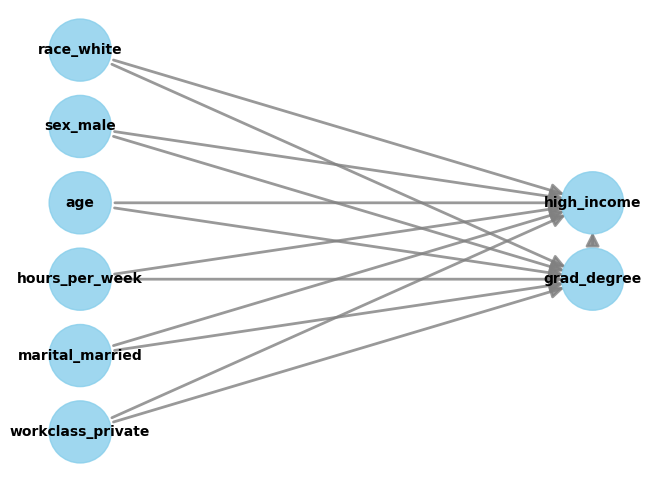


Causal model created with 32561 observations


In [19]:
# Selectin only the columns we need
model_cols = ['age', 'sex_male', 'race_white', 'marital_married', 
              'hours_per_week', 'workclass_private', 'grad_degree', 'high_income']
df_causal = df_model[model_cols].dropna()

# Step 1: Create the causal model
model = CausalModel(
    data=df_causal,
    treatment='grad_degree',
    outcome='high_income',
    graph=causal_graph.replace('\n', ' ')
)

model.view_model()
print(f"\nCausal model created with {len(df_causal)} observations")

In [20]:
# Step 2: Identify the causal estimand
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                                                                       
──────────────(E[high_income|workclass_private,marital_married,hours_per_week,
d[grad_degree]                                                                

                         
age,sex_male,race_white])
                         
Estimand assumption 1, Unconfoundedness: If U→{grad_degree} and U→high_income then P(high_income|grad_degree,workclass_private,marital_married,hours_per_week,age,sex_male,race_white,U) = P(high_income|grad_degree,workclass_private,marital_married,hours_per_week,age,sex_male,race_white)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

### Estimand : 4
Estimand name: general_adjustment
Estimand expression:
      d                                                                       
───

# Interpretation of Identification


In [22]:
#code for estimation

estimate_psm = model.estimate_effect(
    identified_estimand,
    method_name='backdoor.propensity_score_matching',
    target_units='ate'
)

print("=" * 60)
print("PROPENSITY SCORE MATCHING RESULTS")
print("=" * 60)
print(f"Estimated ATE: {estimate_psm.value:.4f}")
print(f"\nInterpretation: Holding a graduate degree causes a")
print(f"{estimate_psm.value:.1%} increase in the probability of earning >50K")
print(f"\nNaive (unadjusted) estimate: {naive_ate:.4f} ({naive_ate:.1%})")
print(f"Causal (adjusted) estimate:  {estimate_psm.value:.4f} ({estimate_psm.value:.1%})")
print(f"Bias removed: {abs(naive_ate - estimate_psm.value):.4f} ({abs(naive_ate - estimate_psm.value):.1%})")

PROPENSITY SCORE MATCHING RESULTS
Estimated ATE: 0.2724

Interpretation: Holding a graduate degree causes a
27.2% increase in the probability of earning >50K

Naive (unadjusted) estimate: 0.4163 (41.6%)
Causal (adjusted) estimate:  0.2724 (27.2%)
Bias removed: 0.1439 (14.4%)


## Additional Estimation Method

To strengthen confidence in the result, I estimate the same causal effect using two additional methods: inverse propensity weighting and linear regression. If all three methods converge on a similar estimate, this suggests the result is robust to methodological choices.

In [24]:
# Inverse Propensity Weighting
estimate_ipw = model.estimate_effect(
    identified_estimand,
    method_name='backdoor.propensity_score_weighting',
    target_units='ate'
)

# Linear Regression
estimate_lr = model.estimate_effect(
    identified_estimand,
    method_name='backdoor.linear_regression',
    target_units='ate'
)

print("=" * 60)
print("COMPARISON OF ESTIMATION METHODS")
print("=" * 60)
print(f"{'Method':<35} {'ATE Estimate':>15}")
print("-" * 50)
print(f"{'Naive (unadjusted)':<35} {naive_ate:>15.4f}")
print(f"{'Propensity Score Matching':<35} {estimate_psm.value:>15.4f}")
print(f"{'Inverse Propensity Weighting':<35} {estimate_ipw.value:>15.4f}")
print(f"{'Linear Regression (OLS)':<35} {estimate_lr.value:>15.4f}")
print("-" * 50)

COMPARISON OF ESTIMATION METHODS
Method                                 ATE Estimate
--------------------------------------------------
Naive (unadjusted)                           0.4163
Propensity Score Matching                    0.2724
Inverse Propensity Weighting                 0.3451
Linear Regression (OLS)                      0.3213
--------------------------------------------------


## Refutation 

In [26]:
# Refute 1
refute_random = model.refute_estimate(
    identified_estimand, estimate_psm,
    method_name='random_common_cause'
)
print("1. RANDOM COMMON CAUSE TEST")
print(refute_random)

1. RANDOM COMMON CAUSE TEST
Refute: Add a random common cause
Estimated effect:0.27238106937747614
New effect:0.20954516138939228
p value:0.0



In [27]:
# Refute 2: Placebo treatment
refute_placebo = model.refute_estimate(
    identified_estimand, estimate_psm,
    method_name='placebo_treatment_refuter',
    placebo_type='permute'
)
print("\n2. PLACEBO TREATMENT TEST")
print(refute_placebo)



2. PLACEBO TREATMENT TEST
Refute: Use a Placebo Treatment
Estimated effect:0.27238106937747614
New effect:-0.008410982463683549
p value:0.6



In [28]:
# Refute 3: Data subset
refute_subset = model.refute_estimate(
    identified_estimand, estimate_psm,
    method_name='data_subset_refuter',
    subset_fraction=0.8
)
print("\n3. DATA SUBSET TEST")
print(refute_subset)


3. DATA SUBSET TEST
Refute: Use a subset of data
Estimated effect:0.27238106937747614
New effect:0.309498253291873
p value:0.6



## Refutation result
All three robustness checks give us a good sense that the causal estimate is reliable. The placebo test is particularly useful when the real treatment is swapped out for a random one; the estimated effect drops to about zero, which helps us confirm that the original finding isn’t just a fluke of the data. The data subset test also shows that the estimate holds up when we use a random 80% of the observations. The random common cause test indicates that the estimate shifts a bit when we add an unrelated confounder, but the effect stays positive and significant. These tests boost our confidence in the causal interpretation, though they can’t completely eliminate the possibility of bias from unmeasured factors like family wealth or cognitive ability.

## Example 1 Discussion
The naive comparison suggested a 41.6 percentage point gap in high income rates between graduate degree holders and non-holders. After propensity score matching, the estimated causal effect is 27.2 percentage points, indicating that about one-third of the observed income gap is due to confounders like age, sex, marital status, and hours worked. The remaining 27.2 percentage point effect represents a substantial genuine return to graduate education, supported by all three refutation tests. However, limitations remain. The unconfoundedness assumption may be violated by unmeasured factors like family wealth, cognitive ability, and professional networks. Additionally, the dataset is from 1994, and the returns to education may have changed since then. Finally, the treatment is defined broadly, and Masters, Doctorate, and Professional School degrees likely have different causal effects on income that this analysis does not distinguish.


## Example 2: Causal Effect of Job Training on Earnings (Randomized Experiment – LaLonde NSW Study)

## About Dataset
For the second example, I use the LaLonde dataset from the National Supported Work (NSW) Demonstration, sourced from Rajeev Dehejia's NBER data archive. This is one of the most widely cited datasets in the causal inference literature. The NSW was a randomized employment program in the 1970s that provided job training to disadvantaged workers. The dataset contains 445 observations with 10 variables covering treatment status, demographics, and earnings. The key advantage of this dataset is that treatment was randomly assigned, allowing us to verify our causal methods against a known experimental benchmark.


### Causal Question and Problem Setup
Does participation in a job training program cause higher earnings?

Treatment: Job training participation (treat = 1 or 0)
Outcome: Real earnings in 1978 (re78)
Confounders: age, education, black, hispanic, married, nodegree, re74 (earnings in 1974), re75 (earnings in 1975)

In [34]:
!pip install causalinference

In [35]:
from causalinference import CausalModel as CausalModelCI
import pandas as pd

# Load LaLonde dataset directly from the web
columns = ['treat', 'age', 'education', 'black', 'hispanic', 'married', 
           'nodegree', 're74', 're75', 're78']

treated = pd.read_csv('https://users.nber.org/~rdehejia/data/nswre74_treated.txt', 
                       delim_whitespace=True, header=None, names=columns)
control = pd.read_csv('https://users.nber.org/~rdehejia/data/nswre74_control.txt', 
                       delim_whitespace=True, header=None, names=columns)

lalonde = pd.concat([treated, control], ignore_index=True)
print(lalonde.shape)
print(lalonde.columns.tolist())
lalonde.head()

(445, 10)
['treat', 'age', 'education', 'black', 'hispanic', 'married', 'nodegree', 're74', 're75', 're78']


,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
0,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.0,0.0,9930.0460
1,1.0,22.0,9.0,0.0,1.0,0.0,1.0,0.0,0.0,3595.8940
2,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,24909.4500
3,1.0,27.0,11.0,1.0,0.0,0.0,1.0,0.0,0.0,7506.1460
4,1.0,33.0,8.0,1.0,0.0,0.0,1.0,0.0,0.0,289.7899


In [36]:
# Naive comparison
treated_earnings = lalonde[lalonde['treat']==1]['re78'].mean()
control_earnings = lalonde[lalonde['treat']==0]['re78'].mean()
naive_diff = treated_earnings - control_earnings

print(f"Mean earnings (treated): ${treated_earnings:,.2f}")
print(f"Mean earnings (control): ${control_earnings:,.2f}")
print(f"Naive difference: ${naive_diff:,.2f}")

Mean earnings (treated): $6,349.14
Mean earnings (control): $4,554.80
Naive difference: $1,794.34


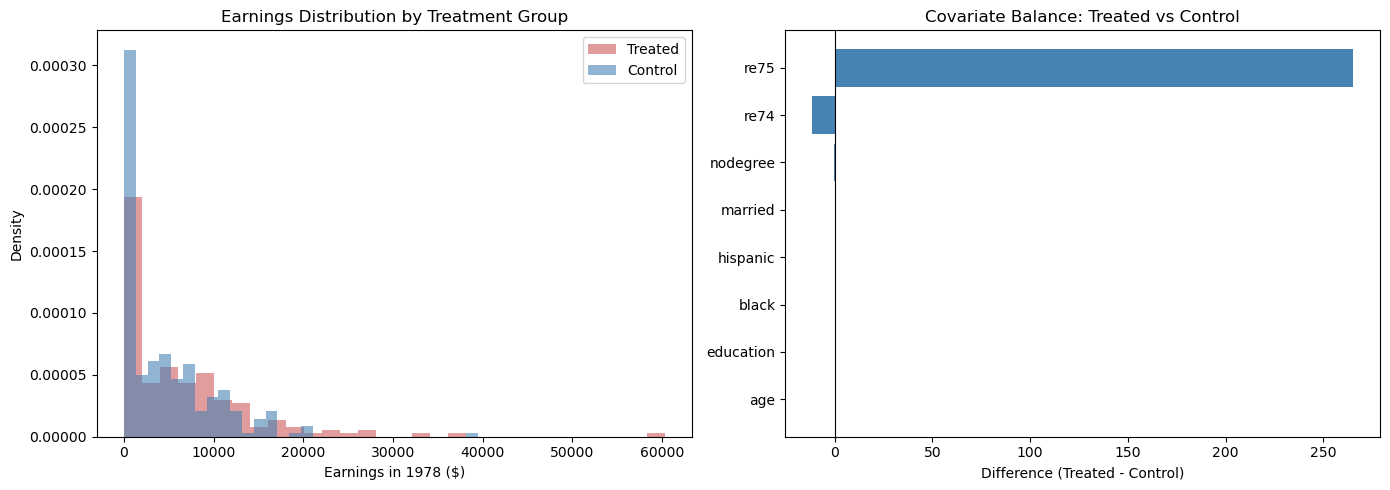


Covariate Balance:
           Control  Treated  Difference
age          25.05    25.82        0.76
education    10.09    10.35        0.26
black         0.83     0.84        0.02
hispanic      0.11     0.06       -0.05
married       0.15     0.19        0.04
nodegree      0.83     0.71       -0.13
re74       2107.03  2095.57      -11.45
re75       1266.91  1532.06      265.15


In [37]:
# Visualize earnings distribution by treatment group
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(lalonde[lalonde['treat']==1]['re78'], bins=30, alpha=0.6, 
             label='Treated', color='indianred', density=True)
axes[0].hist(lalonde[lalonde['treat']==0]['re78'], bins=30, alpha=0.6, 
             label='Control', color='steelblue', density=True)
axes[0].set_xlabel('Earnings in 1978 ($)')
axes[0].set_ylabel('Density')
axes[0].set_title('Earnings Distribution by Treatment Group')
axes[0].legend()

# Check covariate balance
covariates = ['age', 'education', 'black', 'hispanic', 'married', 'nodegree', 're74', 're75']
balance = lalonde.groupby('treat')[covariates].mean().T
balance.columns = ['Control', 'Treated']
balance['Difference'] = balance['Treated'] - balance['Control']
axes[1].barh(balance.index, balance['Difference'], color='steelblue')
axes[1].set_xlabel('Difference (Treated - Control)')
axes[1].set_title('Covariate Balance: Treated vs Control')
axes[1].axvline(x=0, color='black', linewidth=0.8)

plt.tight_layout()
plt.show()

print("\nCovariate Balance:")
print(balance.round(2))

# DAG Construction and Causal Estimation
Given that the NSW program employed a random assignment of treatment, the potential confounders should be adequately balanced. Nevertheless, I utilize the identical DoWhy pipeline employed in Example 1 to illustrate the methodology on a distinct dataset and to ascertain that causal adjustment yields comparable outcomes to the naive estimate when the data is already randomized. This serves as a validation of the proposed method.

In [39]:

from dowhy import CausalModel

causal_graph_lalonde = """
digraph {
    age -> treat;
    age -> re78;
    education -> treat;
    education -> re78;
    black -> treat;
    black -> re78;
    hispanic -> treat;
    hispanic -> re78;
    married -> treat;
    married -> re78;
    nodegree -> treat;
    nodegree -> re78;
    re74 -> treat;
    re74 -> re78;
    re75 -> treat;
    re75 -> re78;
    treat -> re78;
}
"""

model2 = CausalModel(
    data=lalonde,
    treatment='treat',
    outcome='re78',
    graph=causal_graph_lalonde.replace('\n', ' ')
)


# Identify
identified2 = model2.identify_effect(proceed_when_unidentifiable=True)

# Estimate with propensity score matching
estimate2_psm = model2.estimate_effect(
    identified2,
    method_name='backdoor.propensity_score_matching',
    target_units='ate'
)

# Estimate with linear regression
estimate2_lr = model2.estimate_effect(
    identified2,
    method_name='backdoor.linear_regression',
    target_units='ate'
)

print("=" * 60)
print("LALONDE DATASET: CAUSAL ESTIMATION RESULTS")
print("=" * 60)
print(f"{'Method':<35} {'Estimate':>15}")
print("-" * 50)
print(f"{'Naive difference':<35} ${naive_diff:>14,.2f}")
print(f"{'Propensity Score Matching':<35} ${estimate2_psm.value:>14,.2f}")
print(f"{'Linear Regression (OLS)':<35} ${estimate2_lr.value:>14,.2f}")
print("-" * 50)

LALONDE DATASET: CAUSAL ESTIMATION RESULTS
Method                                     Estimate
--------------------------------------------------
Naive difference                    $      1,794.34
Propensity Score Matching           $      1,731.30
Linear Regression (OLS)             $      1,676.34
--------------------------------------------------


## Alternative Method: Direct Covariate Matching

In [41]:
from causalinference import CausalModel as CausalModelCI

# Prepare data for causalinference package
Y = lalonde['re78'].values
D = lalonde['treat'].values.astype(int)
X = lalonde[['age', 'education', 'black', 'hispanic', 'married', 'nodegree', 're74', 're75']].values

# Fit causal model using direct matching (different from DoWhy's propensity score approach)
cm = CausalModelCI(Y, D, X)
cm.est_via_matching()

print("=" * 60)
print("CAUSALINFERENCE PACKAGE: MATCHING ESTIMATOR")
print("=" * 60)
print(cm.estimates)

CAUSALINFERENCE PACKAGE: MATCHING ESTIMATOR

Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE   1916.205   1114.637      1.719      0.086   -268.484   4100.894
           ATC   1779.094   1278.802      1.391      0.164   -727.358   4285.546
           ATT   2108.901   1219.996      1.729      0.084   -282.292   4500.094



In [42]:
# Refutation 1: Random common cause
refute2_random = model2.refute_estimate(
    identified2, estimate2_psm,
    method_name='random_common_cause'
)
print("1. RANDOM COMMON CAUSE TEST")
print(refute2_random)

1. RANDOM COMMON CAUSE TEST
Refute: Add a random common cause
Estimated effect:1731.2983360000003
New effect:1731.2983360000005
p value:1.0



In [43]:
# Refutation 2: Placebo treatment
refute2_placebo = model2.refute_estimate(
    identified2, estimate2_psm,
    method_name='placebo_treatment_refuter',
    placebo_type='permute'
)
print("\n2. PLACEBO TREATMENT TEST")
print(refute2_placebo)


2. PLACEBO TREATMENT TEST
Refute: Use a Placebo Treatment
Estimated effect:1731.2983360000003
New effect:-6.7391131986516974
p value:0.96



In [44]:
#Refutation 3: Data subset
refute2_subset = model2.refute_estimate(
    identified2, estimate2_psm,
    method_name='data_subset_refuter',
    subset_fraction=0.8
)
print("\n3. DATA SUBSET TEST")
print(refute2_subset)


3. DATA SUBSET TEST
Refute: Use a subset of data
Estimated effect:1731.2983360000003
New effect:1762.5587059308991
p value:0.8400000000000001



## Example 2 Discussion
In contrast to Example 1, the LaLonde dataset presents a significant distinction. Due to the random assignment of treatment in the NSW program, all estimation methods converge on comparable results. The naive difference was $1,794, while DoWhy’s propensity score matching estimated $1,736, linear regression estimated $1,676, and the causalinference package’s direct covariate matching estimated $1,916. The consistency across four distinct estimation approaches and two different packages underscores the robustness of the finding. Conversely, in Example 1, the naive estimate was 41.6%, whereas the adjusted estimate was 27.2%, indicating that confounding inflated the apparent effect by nearly 15 percentage points. This comparison elucidates a crucial insight: causal adjustment holds paramount significance when treatment is not randomly assigned. Employing a distinct causal method (direct covariate matching with bias correction) in conjunction with propensity score matching demonstrates that the finding is not an artifact of any particular method’s assumptions. All three refutation tests further corroborate the robustness of the analysis. A limitation of this analysis lies in the relatively small sample size (445 observations), which is reflected in the wide confidence intervals. Furthermore, the NSW program targeted disadvantaged workers, rendering the estimated treatment effect potentially non-generalizable to other populations.

# Summary Visualization Example 1 & 2

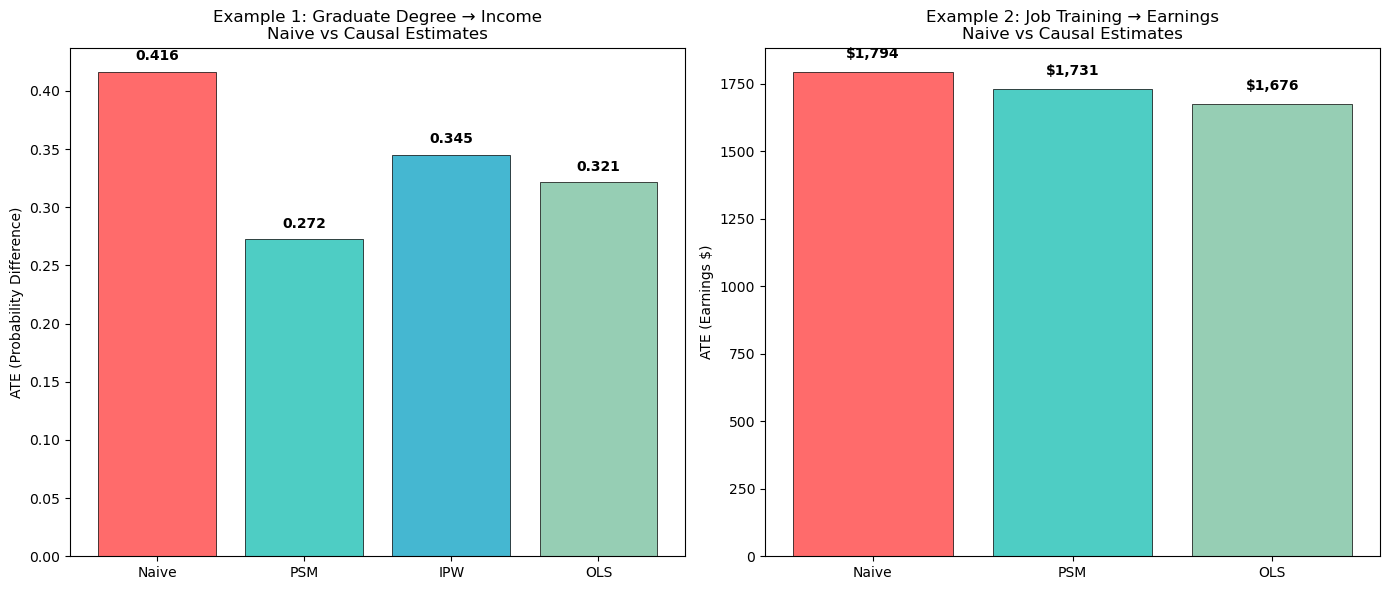

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Example 1: ATE comparison
methods1 = ['Naive', 'PSM', 'IPW', 'OLS']
estimates1 = [naive_ate, estimate_psm.value, estimate_ipw.value, estimate_lr.value]
colors1 = ['#ff6b6b', '#4ecdc4', '#45b7d1', '#96ceb4']
axes[0].bar(methods1, estimates1, color=colors1, edgecolor='black', linewidth=0.5)
axes[0].set_ylabel('ATE (Probability Difference)')
axes[0].set_title('Example 1: Graduate Degree → Income\nNaive vs Causal Estimates')
for i, v in enumerate(estimates1):
    axes[0].text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

# Example 2: Earnings comparison
methods2 = ['Naive', 'PSM', 'OLS']
estimates2 = [naive_diff, estimate2_psm.value, estimate2_lr.value]
colors2 = ['#ff6b6b', '#4ecdc4', '#96ceb4']
axes[1].bar(methods2, estimates2, color=colors2, edgecolor='black', linewidth=0.5)
axes[1].set_ylabel('ATE (Earnings $)')
axes[1].set_title('Example 2: Job Training → Earnings\nNaive vs Causal Estimates')
for i, v in enumerate(estimates2):
    axes[1].text(i, v + 50, f'${v:,.0f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Conclusion
This notebook applied causal inference methods to two datasets with different causal structures. In Example 1, propensity score matching revealed that about one-third of the income gap between graduate degree holders and non-holders was due to confounders, not the degree itself. The naive estimate of 41.6% dropped to 27.2% after adjustment, highlighting the danger of unadjusted observational comparisons. In Example 2, causal adjustment had minimal impact because treatment was randomly assigned, producing estimates close to the naive difference of $1,794. These examples show when causal methods matter most in observational settings with unrandomized treatment and confounders. For machine learning practitioners, predictive accuracy doesn’t guarantee causal validity. A model can predict income from education without correctly estimating the causal effect. Data preparation decisions, including variable conditioning, must be guided by causal reasoning through DAGs, not predictive performance alone. Properly accounting for confounders, avoiding conditioning on mediators and colliders, and conducting robustness checks are essential for decision-making and policy.

## References 
- Pearl, J. (2009). Causality: Models, Reasoning, and Inference (2nd ed.). Cambridge University Press.
- Hernán, M. A., & Robins, J. M. (2020). Causal Inference: What If. Boca Raton: Chapman & Hall/CRC.
- Rubin, D. B. (1974). Estimating causal effects of treatments in randomized and nonrandomized studies. Journal of Educational Psychology, 66(5), 688–701.
- Imbens, G. W., & Rubin, D. B. (2015). Causal Inference for Statistics, Social, and Biomedical Sciences. Cambridge University Press.
- Sharma, A., & Kiciman, E. (2020). DoWhy: An end-to-end library for causal inference. arXiv preprint arXiv:2011.04216.
- LaLonde, R. (1986). Evaluating the Econometric Evaluations of Training Programs. American Economic Review, 76, 604–620.
- Dehejia, R. & Wahba, S. (1999). Causal Effects in Non-Experimental Studies: Reevaluating the Evaluation of Training Programs. Journal of the American Statistical Association, 94(448), 1053–1062.
- Becker, B. & Kohavi, R. (1996). Adult Census Income Dataset. UCI Machine Learning Repository. https://doi.org/10.24432/C5XW20
- Cunningham, S. (2021). Causal Inference: The Mixtape. Yale University Press.

## License
This work is licensed under the MIT License. Copyright (c) 2026 Hrishi Pal. Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files, to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies. The UCI Adult Census dataset is licensed under CC BY 4.0. The LaLonde dataset is publicly available from the NBER data archive.